In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_colwidth', None)  # Display full content of each column
pd.set_option('display.max_columns', None)   # Display all columns
pd.set_option('display.width', 5000)         # Set display width

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
import pandas as pd

df=pd.read_csv("Features.csv")
df.columns

Index(['Transaction Date', 'Value Date', 'Description', 'Reference No./Cheque No.', 'Debit', 'Credit', 'Balance', 'Transaction Type', 'Transaction Mode', 'DR/CR Indicator', 'Transaction ID', 'Recipient Name', 'Bank', 'UPI ID', 'Note', 'dayofweek', 'weekday', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'date_offset', 'is_weekend', 'weekofmonth', 'is_month_start', 'is_month_end', 'is_quarter_start', 'is_quarter_end', 'hour', 'minute', 'second', 'transaction_amount', 'is_large_transaction', 'transaction_count_per_day', 'transaction_count_per_week', 'transaction_count_per_month', 'average_transaction_per_day', 'cumulative_spent_per_day', 'time_since_last_transaction', 'rolling_avg_transaction_7d', 'rolling_avg_transaction_30d'], dtype='object')

In [7]:
import pandas as pd
import numpy as np

missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values[missing_values > 0])


Missing values in each column:
 Reference No./Cheque No.     21
Transaction Mode             22
Transaction ID               34
Recipient Name               34
Bank                        111
UPI ID                      111
Note                         52
dtype: int64


In [5]:
numerical_cols = df.select_dtypes(include=[np.number]).columns
numerical_summary = df[numerical_cols].describe()
numerical_summary


,Debit,Credit,Balance,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,date_offset,is_weekend,weekofmonth,is_month_start,is_month_end,is_quarter_start,is_quarter_end,hour,minute,second,transaction_amount,is_large_transaction,transaction_count_per_day,transaction_count_per_week,transaction_count_per_month,average_transaction_per_day,cumulative_spent_per_day,time_since_last_transaction,rolling_avg_transaction_7d,rolling_avg_transaction_30d
count,741.000000,741.000000,741.000000,741.000000,741.000000,741.000000,741.000000,741.000000,741.000000,741.000000,741.000000,741.000000,741.000000,741.000000,741.000000,741.000000,741.000000,741.0,741.0,741.0,741.000000,741.000000,741.000000,741.000000,741.000000,741.000000,741.000000,741.000000,741.000000,741.000000
mean,295.891903,296.845412,1619.971835,2.916329,2.601889,6.811066,2023.311741,191.715250,15.512821,27.730094,480.128205,0.271255,2.681511,0.031039,0.031039,0.008097,0.012146,0.0,0.0,0.0,295.891903,0.024291,3.229420,18.827260,75.058030,295.891903,774.271930,28.825911,295.554520,293.494796
std,3657.558653,3698.509961,3876.740810,2.009038,0.959700,2.934775,0.631373,89.065637,8.606497,12.700608,330.018265,0.444908,1.242728,0.173541,0.173541,0.089680,0.109610,0.0,0.0,0.0,3657.558653,0.154057,2.574038,8.587537,30.762001,1820.737977,6340.792462,111.852162,1383.053330,661.262341
min,0.000000,0.000000,12.790000,0.000000,1.000000,1.000000,2022.000000,9.000000,1.000000,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,798.920000,1.000000,2.000000,4.000000,2023.000000,120.000000,8.000000,18.000000,197.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.000000,12.000000,50.000000,48.000000,35.000000,0.000000,73.874286,99.133333
50%,56.000000,0.000000,1214.820000,3.000000,2.000000,6.000000,2023.000000,172.000000,16.000000,25.000000,405.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,56.000000,0.000000,2.000000,18.000000,75.000000,100.000000,142.000000,0.000000,115.142857,138.691333
75%,167.000000,10.000000,1753.820000,5.000000,3.000000,9.000000,2024.000000,269.000000,23.000000,39.000000,703.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,167.000000,0.000000,4.000000,25.000000,107.000000,194.666667,339.000000,24.000000,190.000000,211.316667
max,99069.800000,100000.000000,101359.590000,6.000000,4.000000,12.000000,2024.000000,365.000000,31.000000,52.000000,1299.000000,1.000000,5.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,99069.800000,1.000000,13.000000,37.000000,117.000000,24839.700000,99358.800000,2400.000000,14420.971429,3516.950667


In [9]:
from prettytable import PrettyTable
# Detecting Outliers using IQR method
def detect_outliers(col):
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = col[(col < lower_bound) | (col > upper_bound)]
    return outliers

outlier_dict = {}
for col in numerical_cols:
    outliers = detect_outliers(df[col])
    outlier_dict[col] = len(outliers)



table = PrettyTable()
table.field_names = ["Numerical Column", "Number of Outliers"]

for col, outlier_count in outlier_dict.items():
    table.add_row([col, outlier_count])

print(table)


+-----------------------------+--------------------+
|       Numerical Column      | Number of Outliers |
+-----------------------------+--------------------+
|            Debit            |         71         |
|            Credit           |        171         |
|           Balance           |         51         |
|          dayofweek          |         0          |
|           quarter           |         0          |
|            month            |         0          |
|             year            |         0          |
|          dayofyear          |         0          |
|          dayofmonth         |         0          |
|          weekofyear         |         0          |
|         date_offset         |         0          |
|          is_weekend         |         0          |
|         weekofmonth         |         0          |
|        is_month_start       |         23         |
|         is_month_end        |         23         |
|       is_quarter_start      |         6     

In [10]:

# Categorical column analysis
categorical_cols = df.select_dtypes(include=['object']).columns
distinct_counts = {col: df[col].nunique() for col in categorical_cols}
most_frequent = {col: df[col].value_counts().idxmax() for col in categorical_cols}
from prettytable import PrettyTable

# Create a table for the categorical column analysis
table = PrettyTable()

# Set the table field names
table.field_names = ["Categorical Column", "Distinct Values", "Most Frequent Value"]

# Add rows to the table
for col in categorical_cols:
    table.add_row([col, distinct_counts[col], most_frequent[col]])

# Display the table
print(table)


+--------------------------+-----------------+--------------------------+
|    Categorical Column    | Distinct Values |   Most Frequent Value    |
+--------------------------+-----------------+--------------------------+
|     Transaction Date     |       360       |        2024-06-16        |
|        Value Date        |       360       |        16 Jun2024        |
|       Description        |       731       |    CREDIT INTEREST--     |
| Reference No./Cheque No. |       224       | TRANSFER TO4897692162094 |
|     Transaction Type     |        2        |            TO            |
|     Transaction Mode     |        4        |           UPI            |
|     DR/CR Indicator      |        2        |            DR            |
|      Transaction ID      |       647       |        9890160567        |
|      Recipient Name      |       249       |          XX8237          |
|           Bank           |        28       |           YESB           |
|          UPI ID          |       250

In [11]:
# Correlation matrix of numerical features
correlation_matrix = df[numerical_cols].corr()
correlation_matrix


,Debit,Credit,Balance,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,date_offset,is_weekend,weekofmonth,is_month_start,is_month_end,is_quarter_start,is_quarter_end,hour,minute,second,transaction_amount,is_large_transaction,transaction_count_per_day,transaction_count_per_week,transaction_count_per_month,average_transaction_per_day,cumulative_spent_per_day,time_since_last_transaction,rolling_avg_transaction_7d,rolling_avg_transaction_30d
Debit,1.000000,-0.006502,0.007096,0.055722,0.013009,-0.002454,0.047788,-0.002979,-0.005976,-0.003904,-0.012496,0.062050,-0.018146,-0.009480,-0.005549,-0.006115,0.000799,NaN,NaN,NaN,1.000000,0.305561,0.026527,-0.002171,-0.047327,0.497801,0.575287,-0.011332,0.378594,0.178840
Credit,-0.006502,1.000000,0.956587,0.057440,0.013648,-0.001385,0.045730,-0.002663,-0.013850,-0.003641,-0.012796,0.062077,-0.025685,-0.004795,-0.005938,0.009040,0.002395,NaN,NaN,NaN,-0.006502,-0.012673,0.021904,-0.003336,-0.042632,0.491086,-0.008129,-0.001437,-0.004736,-0.004329
Balance,0.007096,0.956587,1.000000,0.035866,-0.024782,-0.059680,0.059479,-0.063912,-0.043084,-0.064416,-0.067985,0.042950,-0.047939,-0.022197,-0.026081,-0.004462,-0.009706,NaN,NaN,NaN,0.007096,0.027685,0.119363,0.052843,0.025700,0.492191,0.011925,-0.009206,0.007215,-0.015360
dayofweek,0.055722,0.057440,0.035866,1.000000,-0.003983,0.012213,-0.020958,0.013257,0.008346,-0.009466,0.071852,0.788913,-0.013935,0.011335,0.011335,-0.003735,0.127353,NaN,NaN,NaN,0.055722,0.045871,0.092303,-0.006557,-0.027363,0.111935,0.096263,0.007428,0.069453,0.022357
quarter,0.013009,0.013648,-0.024782,-0.003983,1.000000,0.959722,-0.200801,0.956769,-0.074723,0.957170,0.327279,-0.018925,-0.075864,0.025612,-0.023072,0.037505,-0.056743,NaN,NaN,NaN,0.013009,0.038078,-0.099190,-0.186591,-0.219893,0.026133,0.025176,0.027893,0.036332,0.057089
month,-0.002454,-0.001385,-0.059680,0.012213,0.959722,1.000000,-0.245305,0.995349,-0.092248,0.995137,0.364752,-0.000025,-0.093220,0.032757,-0.022963,0.005820,-0.018062,NaN,NaN,NaN,-0.002454,0.010165,-0.099798,-0.207411,-0.256169,-0.004930,-0.001194,0.021059,-0.004291,0.020169
year,0.047788,0.045730,0.059479,-0.020958,-0.200801,-0.245305,1.000000,-0.253100,-0.109040,-0.245984,-0.376060,-0.007985,-0.100632,0.047236,-0.002097,0.026958,0.003795,NaN,NaN,NaN,0.047788,0.005400,0.219522,0.313267,0.337491,0.095998,0.085744,-0.079657,0.126802,0.273539
dayofyear,-0.002979,-0.002663,-0.063912,0.013257,0.956769,0.995349,-0.253100,1.000000,0.003844,0.999718,0.367644,-0.000708,0.000510,0.003720,0.007130,-0.009016,0.000355,NaN,NaN,NaN,-0.002979,0.012619,-0.101518,-0.211216,-0.259146,-0.005983,-0.001615,0.018148,-0.001078,0.009809
dayofmonth,-0.005976,-0.013850,-0.043084,0.008346,-0.074723,-0.092248,-0.109040,0.003844,1.000000,0.002888,-0.003540,-0.007085,0.975025,-0.302009,0.313238,-0.152458,0.191071,NaN,NaN,NaN,-0.005976,0.025245,-0.023801,-0.028950,-0.013516,-0.012004,-0.005667,-0.031784,0.031767,-0.119821
weekofyear,-0.003904,-0.003641,-0.064416,-0.009466,0.957170,0.995137,-0.245984,0.999718,0.002888,1.000000,0.364017,-0.018594,0.000112,0.003806,0.006872,-0.008757,-0.002496,NaN,NaN,NaN,-0.003904,0.011643,-0.102229,-0.209226,-0.256602,-0.007842,-0.003184,0.017447,-0.001749,0.011264


In [12]:
print("Start date:", df['Transaction Date'].min())
print("End date:", df['Transaction Date'].max())

Start date: 2022-05-31
End date: 2024-11-06


In [13]:
print("Min transaction amount:", df['transaction_amount'].min())
print("Max transaction amount:", df['transaction_amount'].max())

Min transaction amount: 0.0
Max transaction amount: 99069.8


In [14]:
weekend_spending = df[df["is_weekend"] == 1]["Balance"].sum()
weekday_spending = df[df["is_weekend"] == 0]["Balance"].sum()

print(f"Weekend Spending: {abs(weekend_spending)}")
print(f"Weekday Spending: {abs(weekday_spending)}")

# plt.bar(["Weekday", "Weekend"], [abs(weekday_spending), abs(weekend_spending)], color=["blue", "red"])
# plt.title("Weekday vs Weekend Spending")
# plt.ylabel("Amount Spent")
# plt.show()


Weekend Spending: 380433.88999999996
Weekday Spending: 819965.24


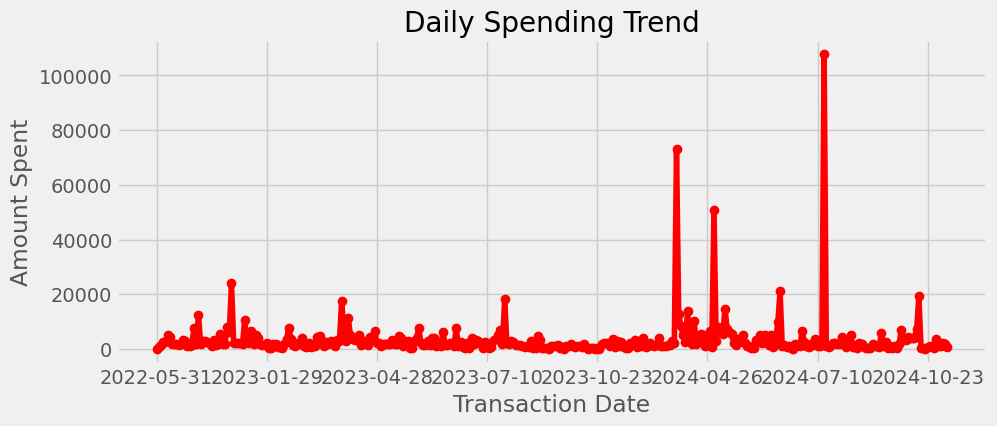

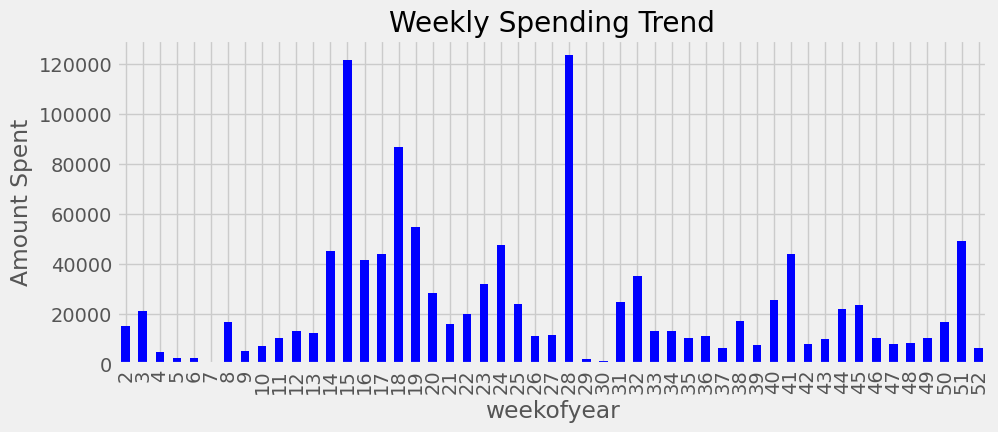

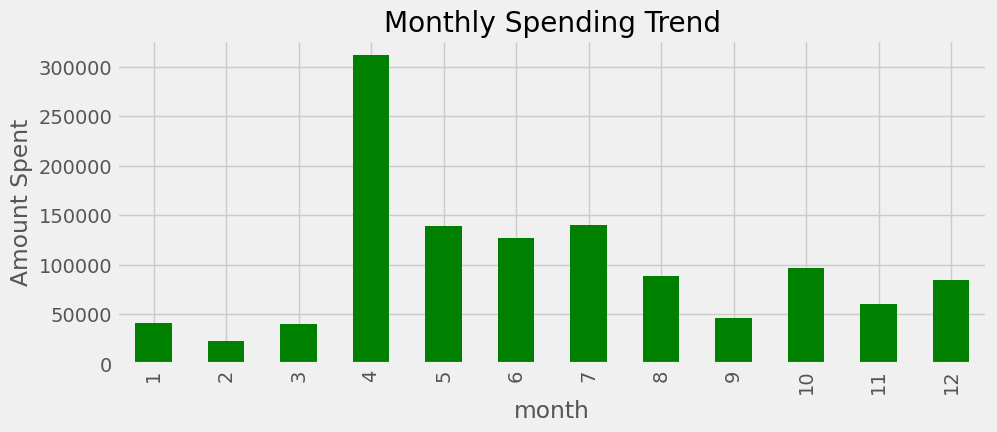

In [15]:
# Daily Spending
daily_spending = df.groupby("Transaction Date")["Balance"].sum()
plt.figure(figsize=(10, 4))
daily_spending.plot(kind="line", marker="o", color="red")
plt.title("Daily Spending Trend")
plt.ylabel("Amount Spent")
plt.show()

# Weekly Spending
weekly_spending = df.groupby("weekofyear")["Balance"].sum()
plt.figure(figsize=(10, 4))
weekly_spending.plot(kind="bar", color="blue")
plt.title("Weekly Spending Trend")
plt.ylabel("Amount Spent")
plt.show()

# Monthly Spending
monthly_spending = df.groupby("month")["Balance"].sum()
plt.figure(figsize=(10, 4))
monthly_spending.plot(kind="bar", color="green")
plt.title("Monthly Spending Trend")
plt.ylabel("Amount Spent")
plt.show()
